# Comparison between variant annotation databases

Created: **31/07/18**  
Last modified: **01/08/18**

**Goal:** ...  
This notebook is divided in ? parts:

* **1. Bla**: Bla

**Refs:**
* `annotating.ipynb` [Pierre]
* `custom_tools.R` [Pierre](./annotating.ipynb)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CIViC" data-toc-modified-id="CIViC-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CIViC</a></span><ul class="toc-item"><li><span><a href="#Join-database-with-impact" data-toc-modified-id="Join-database-with-impact-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Join database with impact</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Cancer-Genome-Interpreter" data-toc-modified-id="Cancer-Genome-Interpreter-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Cancer Genome Interpreter</a></span></li><li><span><a href="#My-Cancer-Genome" data-toc-modified-id="My-Cancer-Genome-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>My Cancer Genome</a></span></li></ul></li></ul></div>

***

In [1]:
source("../../../src/utils/custom_tools.R")
setup_environment()

In [2]:
impact <- get_cleaned_impact()
impact <- add_features(impact, annotations = TRUE, oncokb = TRUE)

Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 1 has 248513 rows to replace 248498 rows”Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 2 has 248513 rows to replace 248498 rows”Warning message in `[<-.data.frame`(`*tmp*`, , c("is_a_hotspot", "is_a_3d_hotspot", :
“replacement element 3 has 248513 rows to replace 248498 rows”

<font color='red'> Please make sure to run the script `get_data.sh` in `data/other_databases` to download the different databases used in the rest of the notebook.</font>

We will study different databases available online and compare them with OncoKB:
* [CIViC](https://civicdb.org/)

TODO:
* Read CIViC paper page 1 par on the right.

## CIViC

**Website:** https://civicdb.org/  
**Article:** https://www.nature.com/articles/ng.3774, published in Nature in January 2017  
**Author:** MIT (Massachusettes Institute of Technology)

*Pierre - "It's a crowdsourcing OncoKB."*

From the article and https://civicdb.org/faq:
* CIViC is an community expert-crowdsourced knowledgebase for clinical interpretation of variants in cancer.
* It describes the therapeutic, prognostic, diagnosic and predisposing relevance of inherited and somatic variants of all types.
* Present itself as more open and transparent that the concurrency.
* National team of experts collaborating remotely within a centralized curation interface. Agreement between at least two independant contributors (and at least one must be an expert editor) before acceptance of new evidence or revisions of existing content. Validated curators can add a variant description if there is evidence link to cancer with some clinical relevance
* Scoring system of the variants.
* All variant types supported as well as all variants origine (somatic mutation, germline mutation and germline polymorphism).
* 1,678 curated interpretations of clinical relevance for **713 variants** affecting **283 genes**.

### Join database with impact

Data downloaded from https://civicdb.org/releases under "Variant Summaries", 01/07/18 version.

In [112]:
civic <- read.table("../../../data/other_databases/CIViC_01-Jul-2018-VariantSummaries.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

In [113]:
nrow(civic)
length(unique(civic$gene))

[1] 1885

[1] 353

In [114]:
colnames(civic)

[1] "variant_id"                 "variant_civic_url"         
 [3] "gene"                       "entrez_id"                 
 [5] "variant"                    "summary"                   
 [7] "variant_groups"             "chromosome"                
 [9] "start"                      "stop"                      
[11] "reference_bases"            "variant_bases"             
[13] "representative_transcript"  "ensembl_version"           
[15] "reference_build"            "chromosome2"               
[17] "start2"                     "stop2"                     
[19] "representative_transcript2" "variant_types"             
[21] "hgvs_expressions"           "last_review_date"          
[23] "civic_actionability_score"

In [115]:
interesting_columns <- c(
"gene",
"variant",
"chromosome",
"start",
"stop",
"reference_bases",
"variant_bases",
"representative_transcript",
"ensembl_version",
"reference_build",
"variant_types",
"hgvs_expressions",
"civic_actionability_score")

In [116]:
head(civic[, interesting_columns], 10)

gene,variant,chromosome,start,stop,reference_bases,variant_bases,representative_transcript,ensembl_version,reference_build,variant_types,hgvs_expressions,civic_actionability_score
ABL1,BCR-ABL,22,23522397,23632600,,,ENST00000305877.8,75,GRCh37,transcript_fusion,,238.0
ABL1,BCR-ABL T334I,9,133748283,133748283,C,T,ENST00000372348.2,75,GRCh37,"transcript_fusion,missense_variant","NM_007313.2:c.1001C>T,NP_005148.2:p.Thr315Ile,ENST00000372348.2:c.1001C>T,NC_000009.11:g.133748283C>T",54.0
ABL1,BCR-ABL E255K,9,133738363,133738363,G,A,ENST00000318560.5,75,GRCh37,"transcript_fusion,missense_variant","NC_000009.11:g.133738363G>A,NM_005157.5:c.763G>A,NP_005148.2:p.Glu255Lys,ENST00000318560.5:c.763G>A",17.0
AKT1,E17K,14,105246551,105246551,C,T,ENST00000407796.2,75,GRCh37,missense_variant,"NC_000014.8:g.105246551C>T,NM_001014432.1:c.49G>A,NP_001014432.1:p.Glu17Lys,ENST00000407796.2:c.49G>A",32.5
ALK,EML4-ALK,2,42396490,42522656,,,ENST00000318522.5,75,GRCh37,transcript_fusion,,48.0
ALK,EML4-ALK C1156Y,2,29445258,29445258,C,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3467G>A,NC_000002.11:g.29445258C>T,NM_004304.4:c.3467G>A,NP_004295.2:p.Cys1156Tyr",19.0
ALK,EML4-ALK L1196M,2,29443631,29443631,G,T,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3586C>A,NC_000002.11:g.29443631G>T,NM_004304.4:c.3586C>A,NP_004295.2:p.Leu1196Met",31.0
ALK,F1174L,2,29443695,29443695,G,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3522C>A,NP_004295.2:p.Phe1174Leu,NC_000002.11:g.29443695G>T,ENST00000389048.3:c.3522C>A",33.5
ALK,R1275Q,2,29432664,29432664,C,T,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3824G>A,NP_004295.2:p.Arg1275Gln,NC_000002.11:g.29432664C>T,ENST00000389048.3:c.3824G>A",23.0
ARAF,S214C,X,47426121,47426121,C,G,ENST00000377045.4,75,GRCh37,missense_variant,"NC_000023.10:g.47426121C>G,NM_001654.4:c.641C>G,NP_001645.1:p.Ser214Cys,ENST00000377045.4:c.641C>G",11.0


We will join the database using `join_key = chromosome`\_`start`_`reference_bases`_`variant_bases`, even though a lot of keys will be invalid no better alternative was found.

In [117]:
# creating the key
civic$join_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep = "_")
civic$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

In [118]:
nrow(civic[civic$join_key == "no_key",])
nrow(civic)

# delete the rows where we couldn't compute a key
civic <- civic[civic$join_key != "no_key",]

[1] 1082

[1] 1885

In [119]:
# check the unicity of `join_key`
length(unique(civic$join_key))
nrow(civic)

repeated_key <- civic %>% group_by(join_key) %>% filter(n() > 1)
repeated_key[order(repeated_key$join_key), interesting_columns]

[1] 797

[1] 803

gene,variant,chromosome,start,stop,reference_bases,variant_bases,representative_transcript,ensembl_version,reference_build,variant_types,hgvs_expressions,civic_actionability_score
FLT3,TKD MUTATION,13,28592642,28592642,C,A,ENST00000241453.7,75,GRCh37,nonsynonymous_variant,NC_000013.10:g.28592642C>A,120.0
FLT3,D835,13,28592642,28592642,C,A,ENST00000241453.7,75,GRCh37,protein_altering_variant,NC_000013.10:g.28592642C>A,46.0
ERBB2,P780INS,17,37881011,37881012,,GGCTCCCCA,ENST00000269571.5,75,GRCh37,inframe_insertion,"ENST00000269571.5:c.2340_2341insGGCTCCCCA,NC_000017.10:g.37881011_37881012insGGCTCCCCA",12.5
ERBB2,G778_P780DUP,17,37881011,37881012,,GGCTCCCCA,ENST00000269571.5,75,GRCh37,inframe_insertion,NM_004448.3:c.2332_2340dupGGCTCCCCA,15.0
ALK,EML4-ALK G1269A,2,29432682,29432682,C,G,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3806G>C,NC_000002.11:g.29432682C>G,NM_004304.4:c.3806G>C,NP_004295.2:p.Gly1269Ala",17.5
ALK,ALK FUSION G1269A,2,29432682,29432682,C,G,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","ENST00000389048.3:c.3806G>C,NC_000002.11:g.29432682C>G,NM_004304.4:c.3806G>C,NP_004295.2:p.Gly1269Ala",10.0
ALK,F1245C,2,29436859,29436859,A,C,ENST00000389048.3,75,GRCh37,missense_variant,"NM_004304.4:c.3734T>G,NP_004295.2:p.Phe1245Cys,NC_000002.11:g.29436859A>C,ENST00000389048.3:c.3734T>G",10.5
ALK,ALK FUSION F1245C,2,29436859,29436859,A,C,ENST00000389048.3,75,GRCh37,"transcript_fusion,missense_variant","NM_004304.4:c.3734T>G,NP_004295.2:p.Phe1245Cys,NC_000002.11:g.29436859A>C,ENST00000389048.3:c.3734T>G",14.5
VHL,P59fs (c.173_174insC),3,10183704,10183705,,C,ENST00000256474.2,75,GRCh37,frameshift_truncation,"ENST00000256474.2:c.173_174insC,NP_000542.1:p.Pro59AlafsTer73,NM_000551.3:c.173_174insC,NC_000003.11:g.10183704_10183705insC",7.5
VHL,R58fs (c.173_174insC),3,10183704,10183705,,C,ENST00000256474.2,75,GRCh37,frameshift_variant,ENST00000256474.2:c.173_174insC,0.0


[1] 791

In [123]:
# delete the repeated keys
civic <- civic[! civic$join_key %in% repeated_key$join_key,]
nrow(civic)

[1] 791

In [124]:
impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$join_key] <- "yes"

### Results


    no    yes 
235638  12860 

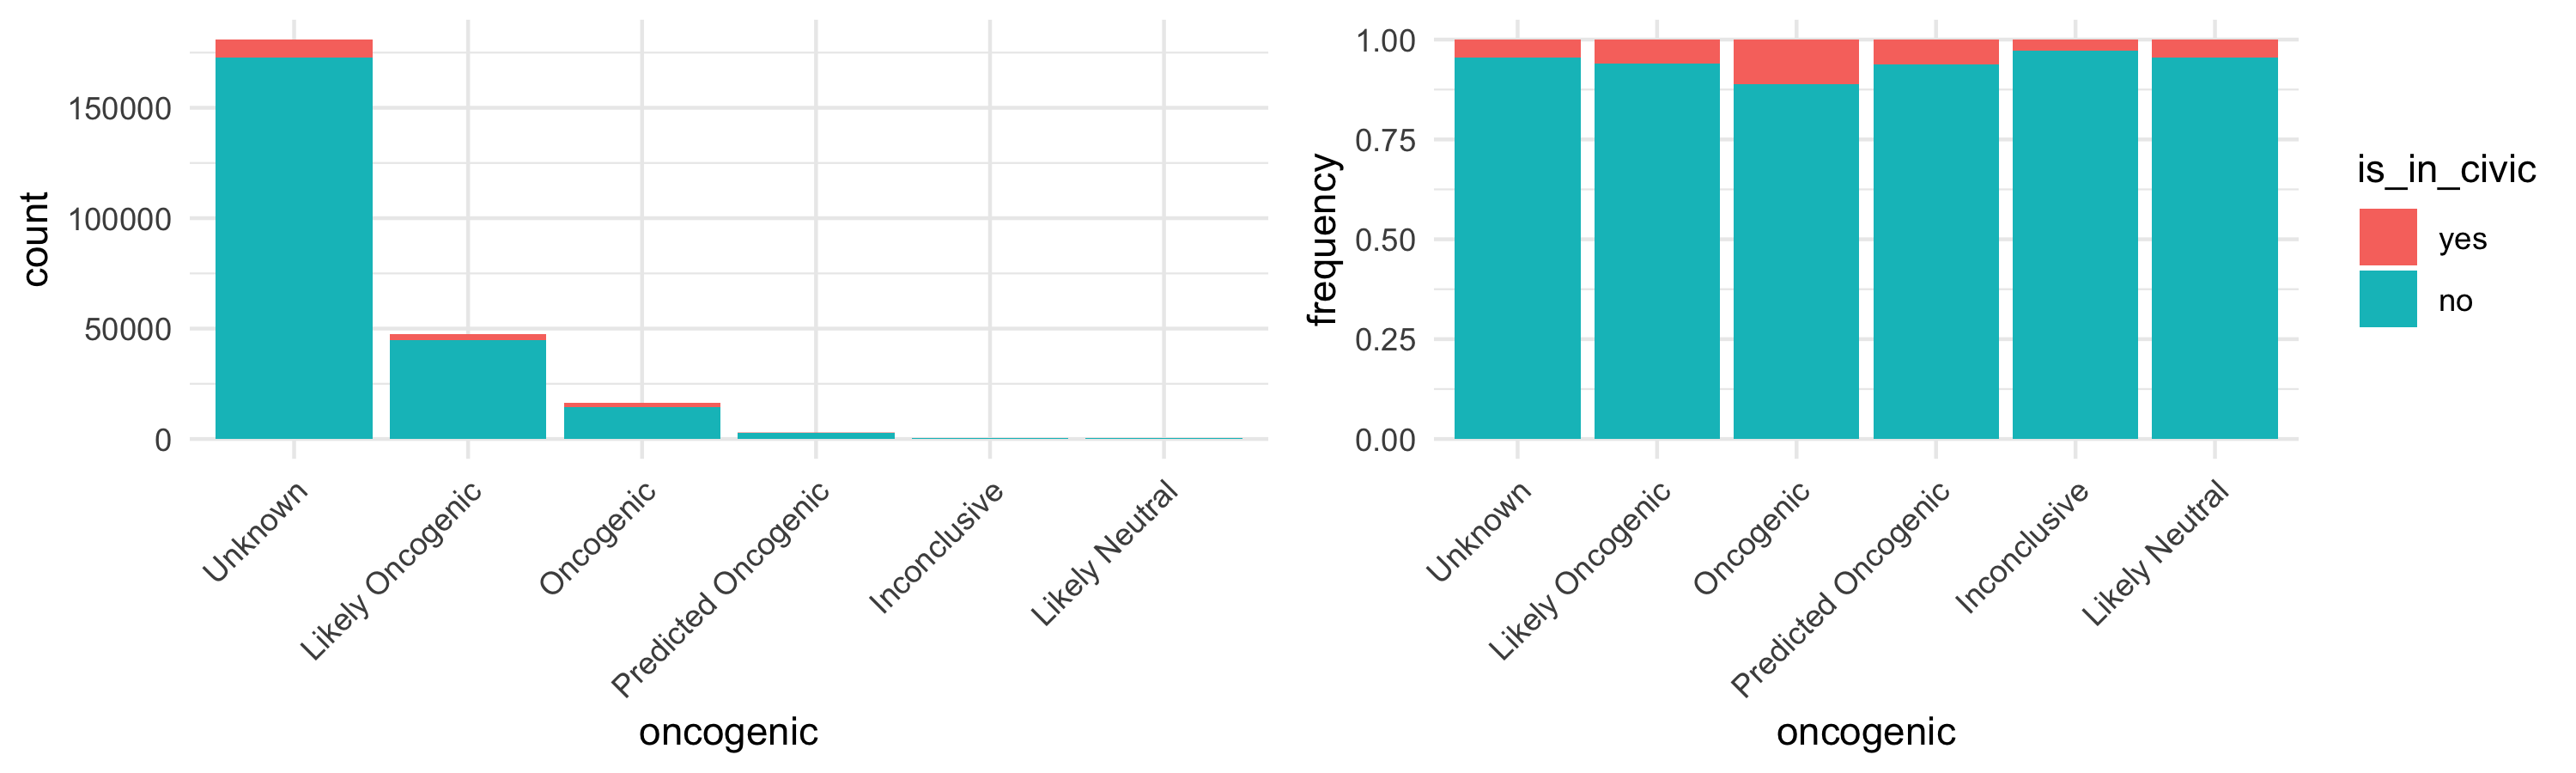

In [125]:
table(impact$is_in_civic)
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_civic")

### Cancer Genome Interpreter

**[Cancer Genome Interpreter](https://www.cancergenomeinterpreter.org/home)**  
See https://www.cancergenomeinterpreter.org/faq for informations:  
* Designed to support the identification of tumor alterations that drive the disease and detect those that may be therapeutically actionable.
* CGI relies on existing knowledge collected from several resources and on computational methods that annotate the alterations in a tumor according to distinct levels of evidence.
* It identifies known driver alterations and annotates and classifies the remaining variants of unknown significance. Finally, alterations that are biomarkers of drug effect are identified according to current evidences.
* Alterations that are clinically or experimentally validated to drive tumor phenotypes –previously culled from public sources-- are identified by the CGI, whereas the effect of the remaining alterations of uncertain significance are predicted using in silico approaches, such as OncodriveMUT (for mutations).

It is OncoKB + OncodriveMUT.

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [90]:
cgi <- read.table("data/other_databases/catalog_of_validated_oncogenic_mutations.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [91]:
head(cgi)

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040


In [93]:
length(unique(cgi$gene))
nrow(cgi)

[1] 247

[1] 5601

In [97]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

In [98]:
table(impact$is_in_cgi)


    no    yes 
219825  28673 

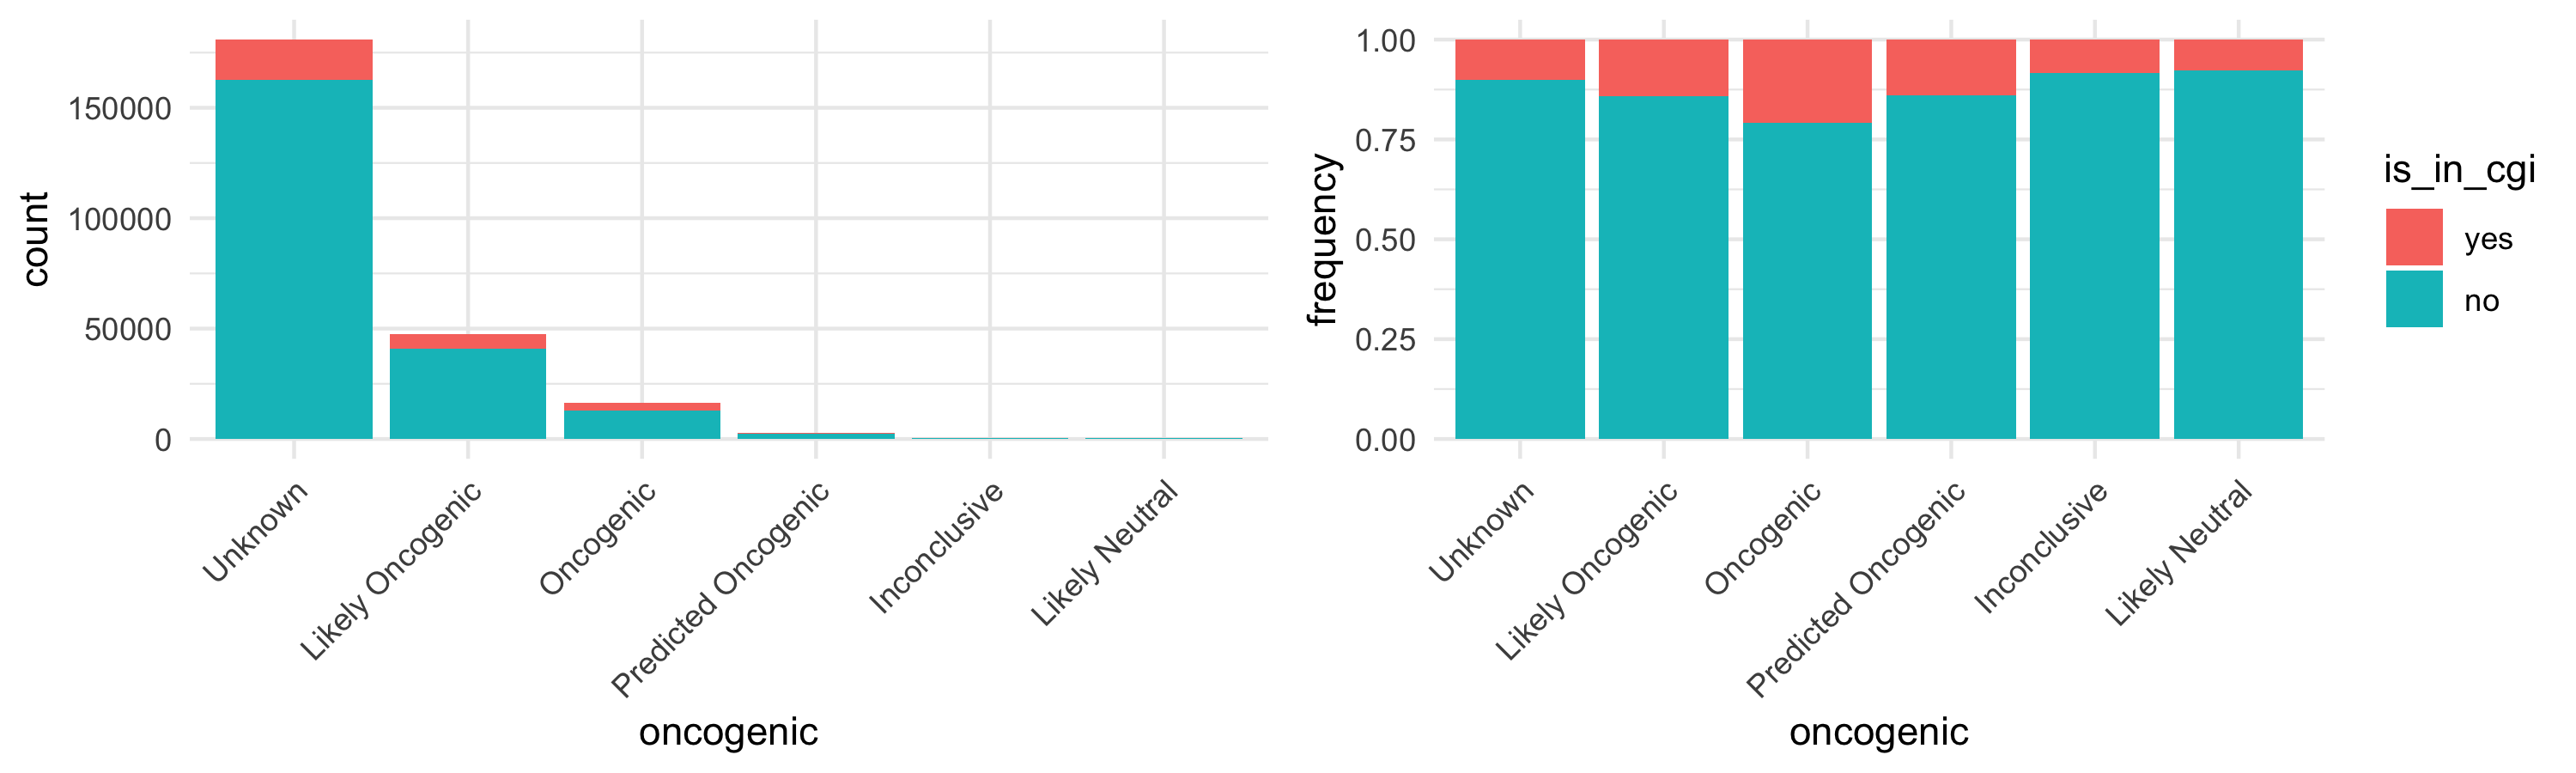

In [99]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_cgi")

### My Cancer Genome

**[My Cancer Genome](https://www.mycancergenome.org)**  
See https://www.mycancergenome.org/about/what-is-my-cancer-genome/ for informations:
* My Cancer Genome is a precision cancer medicine knowledge resource for physicians, patients, caregivers and researchers.
* It gives information on what mutations make cancers grow and related therapeutic implications, including available clinical trials.

It is OncoKB.

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

In [90]:
cgi <- read.table("data/other_databases/catalog_of_validated_oncogenic_mutations.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

In [91]:
head(cgi)

gene,gdna,protein,transcript,info,context,cancer_acronym,source,reference
ABCB4,chr7:g.87053221C>T,.,ENST00000265723,CSQN=SpliceDonorSNV;C2=SpliceDonorOfExon17_At_chr7:87053221;aliases=ENSP00000265723;source=Ensembl,germline,HC-PR,ClinVar,Clinvar:NM_018849.2(ABCB4):c.2211+1G>A AND Progressive familial intrahepatic cholestasis 3
ABL1,chr9:g.133738306G>A,p.E236K,ENST00000318560,CSQN=Missense;codon_pos=133738306-133738307-133738308;ref_codon_seq=GAG;aliases=ENSP00000323315;source=Ensembl,somatic,CML,DoCM,PMID:21562040
ABL1,chr9:g.133738309A>G,p.M237V,ENST00000318560,"CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738309_133738311delATGinsGTA,chr9:g.133738309_133738311delATGinsGTC,chr9:g.133738309_133738311delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738325T>C,p.I242T,ENST00000318560,"CSQN=Missense;reference_codon=ATC;candidate_codons=ACA,ACG,ACT,ACC;candidate_mnv_variants=chr9:g.133738325_133738326delTCinsCA,chr9:g.133738325_133738326delTCinsCG,chr9:g.133738325_133738326delTCinsCT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040
ABL1,chr9:g.133738330A>G,p.M244V,ENST00000318560,"CSQN=Missense;codon_pos=133738330-133738331-133738332;ref_codon_seq=ATG;aliases=ENSP00000323315;source=Ensembl__CSQN=Missense;reference_codon=ATG;candidate_codons=GTA,GTC,GTG,GTT;candidate_mnv_variants=chr9:g.133738330_133738332delATGinsGTA,chr9:g.133738330_133738332delATGinsGTC,chr9:g.133738330_133738332delATGinsGTT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,DoCM__Biomarker__OncoKB,PMID:21562040__PMID:20367437__PMID:21895409__PMID:25157968__PMID:12399961__PMID:12576318__PMID:23676790__PMID:18223278__PMID:12623848__PMID:21888027
ABL1,chr9:g.133738340A>G,p.K247R,ENST00000318560,"CSQN=Missense;reference_codon=AAG;candidate_codons=AGG,AGA,CGA,CGC,CGG,CGT;candidate_mnv_variants=chr9:g.133738340_133738341delAGinsGA,chr9:g.133738339_133738340delAAinsCG,chr9:g.133738339_133738341delAAGinsCGA,chr9:g.133738339_133738341delAAGinsCGC,chr9:g.133738339_133738341delAAGinsCGT;aliases=ENSP00000323315;source=Ensembl",somatic,CML,Biomarker,PMID:21562040


In [93]:
length(unique(cgi$gene))
nrow(cgi)

[1] 247

[1] 5601

In [97]:
impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

In [98]:
table(impact$is_in_cgi)


    no    yes 
219825  28673 

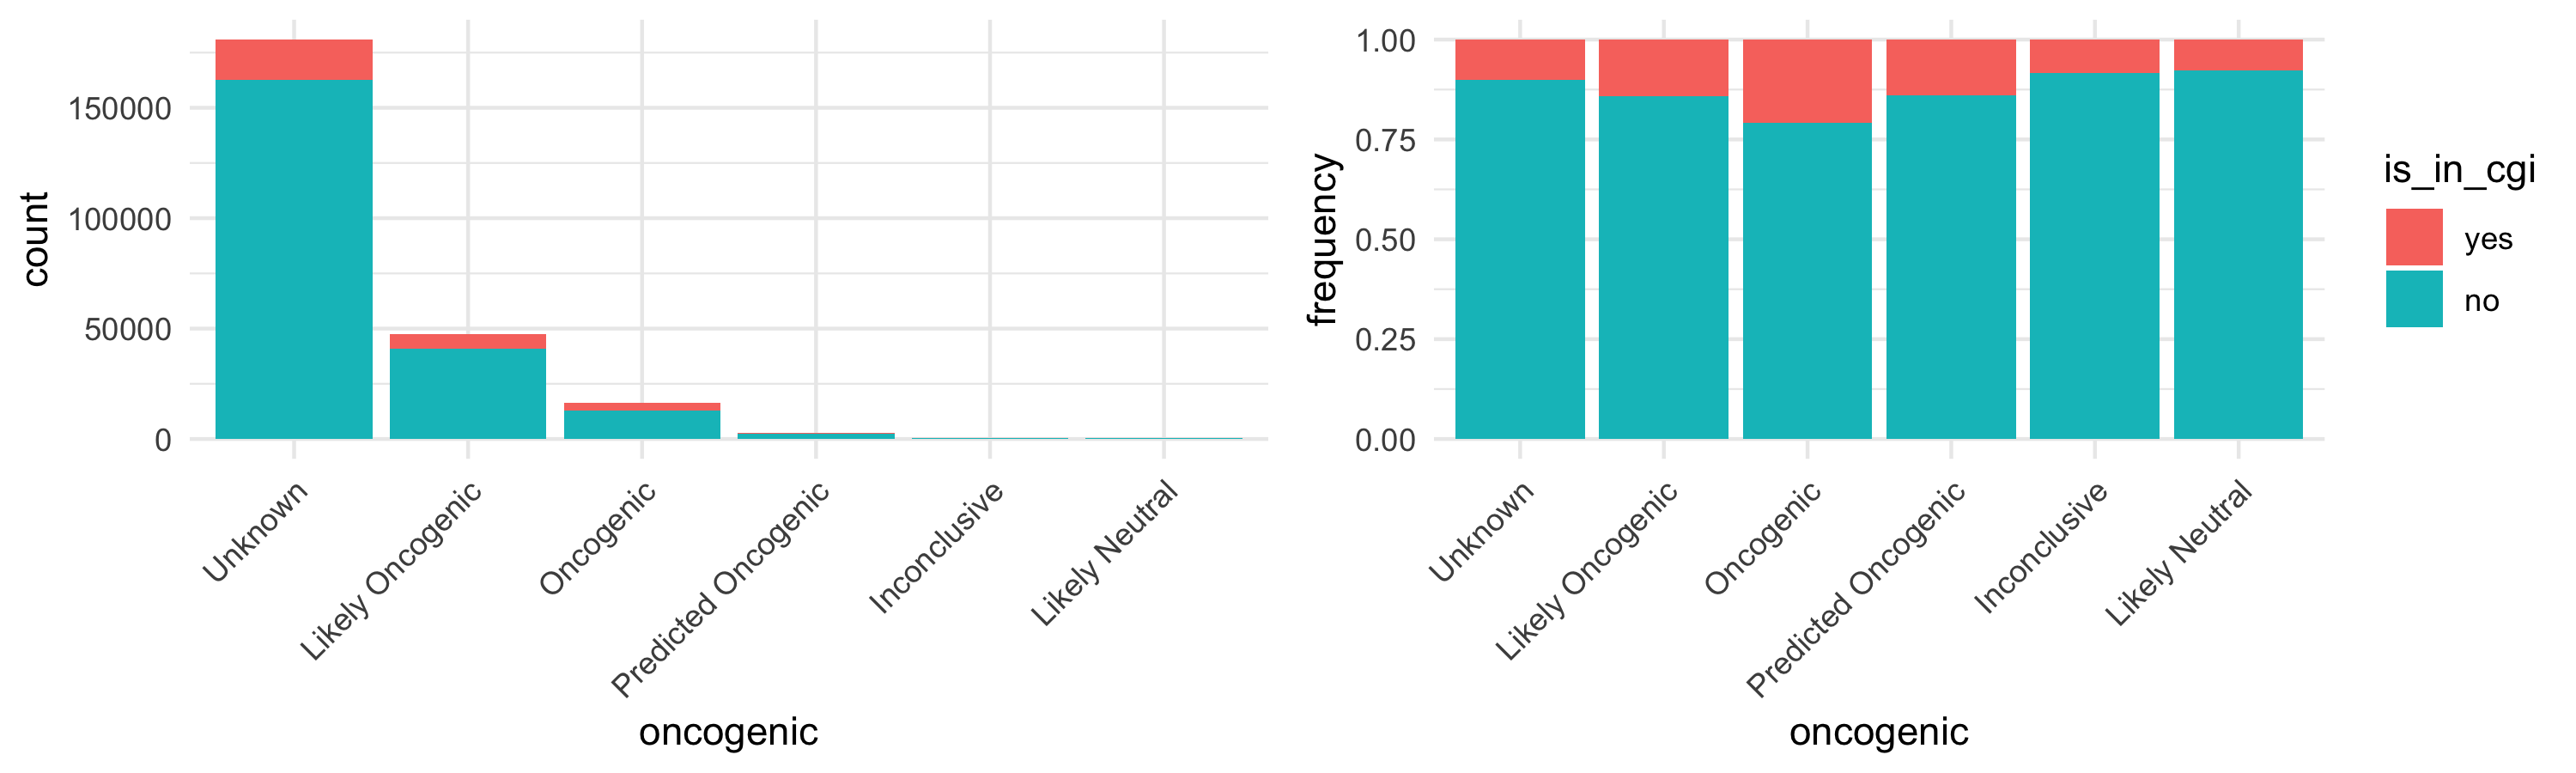

In [99]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_cgi")

In [ ]:
## Other tools available

<font color='red'> Please make sure to run the script `get_data.sh` in `data/other_databases` to download the different databases used in the rest of the notebook.</font>

We will study different databases available online and compare them with OncoKB:
* [CIViC](https://civicdb.org/)

TODO:
* Read CIViC paper page 1 par on the right.

### CIViC

**Website:** https://civicdb.org/  
**Article:** https://www.nature.com/articles/ng.3774, published in Nature in January 2017  
**Author:** MIT (Massachusettes Institute of Technology)

*Pierre - "It's a crowdsourcing OncoKB."*

From the article and https://civicdb.org/faq:
* CIViC is an community expert-crowdsourced knowledgebase for clinical interpretation of variants in cancer.
* It describes the therapeutic, prognostic, diagnosic and predisposing relevance of inherited and somatic variants of all types.
* Present itself as more open and transparent that the concurrency.
* National team of experts collaborating remotely within a centralized curation interface. Agreement between at least two independant contributors (and at least one must be an expert editor) before acceptance of new evidence or revisions of existing content. Validated curators can add a variant description if there is evidence link to cancer with some clinical relevance
* Scoring system of the variants.
* All variant types supported as well as all variants origine (somatic mutation, germline mutation and germline polymorphism).
* 1,678 curated interpretations of clinical relevance for **713 variants** affecting **283 genes**.

Data downloaded from https://civicdb.org/releases under "Variant Summaries", 01/07/18 version.

civic <- read.table("../../../data/other_databases/CIViC_01-Jul-2018-VariantSummaries.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE, quote = "")

nrow(civic)
length(unique(civic$gene))

colnames(civic)

interesting_columns <- c(
"gene",
"variant",
"chromosome",
"start",
"stop",
"reference_bases",
"variant_bases",
"representative_transcript",
"ensembl_version",
"reference_build",
"variant_types",
"hgvs_expressions",
"civic_actionability_score")

head(civic[, interesting_columns], 10)

We will join the database using `join_key = chromosome`\_`start`_`reference_bases`_`variant_bases`, even though a lot of keys will be invalid no better alternative was found.

# creating the key
civic$join_key <- paste(civic$chromosome, civic$start, civic$reference_bases, civic$variant_bases, sep = "_")
civic$join_key[civic$chromosome == "" |
               civic$start == "" |
               (civic$reference_bases == "" & civic$variant_bases   == "")] <- "no_key"

nrow(civic[civic$join_key == "no_key",])
nrow(civic)

# delete the rows where we couldn't compute a key
civic <- civic[civic$join_key != "no_key",]

# check the unicity of `join_key`
length(unique(civic$join_key))
nrow(civic)

repeated_key <- civic %>% group_by(join_key) %>% filter(n() > 1)
repeated_key[order(repeated_key$join_key), interesting_columns]

# delete the repeated keys
civic <- civic[! civic$join_key %in% repeated_key$join_key,]
nrow(civic)

impact$is_in_civic <- "no"
impact$is_in_civic[impact$mut_key %in% civic$join_key] <- "yes"

table(impact$is_in_civic)
plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_civic")

### Cancer Genome Interpreter

**[Cancer Genome Interpreter](https://www.cancergenomeinterpreter.org/home)**  
See https://www.cancergenomeinterpreter.org/faq for informations:  
* Designed to support the identification of tumor alterations that drive the disease and detect those that may be therapeutically actionable.
* CGI relies on existing knowledge collected from several resources and on computational methods that annotate the alterations in a tumor according to distinct levels of evidence.
* It identifies known driver alterations and annotates and classifies the remaining variants of unknown significance. Finally, alterations that are biomarkers of drug effect are identified according to current evidences.
* Alterations that are clinically or experimentally validated to drive tumor phenotypes –previously culled from public sources-- are identified by the CGI, whereas the effect of the remaining alterations of uncertain significance are predicted using in silico approaches, such as OncodriveMUT (for mutations).

It is OncoKB + OncodriveMUT.

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

cgi <- read.table("data/other_databases/catalog_of_validated_oncogenic_mutations.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

head(cgi)

length(unique(cgi$gene))
nrow(cgi)

impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

table(impact$is_in_cgi)

plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_cgi")

### My Cancer Genome

**[My Cancer Genome](https://www.mycancergenome.org)**  
See https://www.mycancergenome.org/about/what-is-my-cancer-genome/ for informations:
* My Cancer Genome is a precision cancer medicine knowledge resource for physicians, patients, caregivers and researchers.
* It gives information on what mutations make cancers grow and related therapeutic implications, including available clinical trials.

It is OncoKB.

Data downloaded from https://www.cancergenomeinterpreter.org/mutations, 01/17/18 version.

cgi <- read.table("data/other_databases/catalog_of_validated_oncogenic_mutations.tsv",
                    sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

head(cgi)

length(unique(cgi$gene))
nrow(cgi)

impact$is_in_cgi <- "no"
impact$is_in_cgi[impact$HGVSp_Short %in% cgi$protein] <- "yes"

table(impact$is_in_cgi)

plot_contingency_table_as_histograms(impact, "oncogenic", "is_in_cgi")

